# ShLiDaNa TEXT GENERATOR v1

Create a model that will predict the next word in a text sequence, implementing and training using a corpus of Different datasets, while also creating some helper functions to pre-process the data.

OUR TEAM:

| Name | NIM |
|---|---|
|Shahran Kurnia Ramadhan|21/476650/PA/20592|
|Muhammad Linggar Ryanidha|21/475209/PA/20548|
|Daniel Ardi Chandra|21/479046/PA/20780|
|I Gusti Agung Premananda |21/473829/PA/20432|

In [106]:
import numpy as np
import re
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

   # Your code here
   

In [107]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 18367074486927605212
xla_global_id: -1
]


In [108]:
# Define path for file with datasets
dataset = '..\Datasets\VGCoST_VideoGameDialogue_Corpus\ENG\Portal_merged.txt'

# Read the data
with open(dataset, encoding='ISO-8859-1') as f:
    data = f.read()

# Remove unwanted characters using regex
data = re.sub(r"[\"']", "", data)

# Convert to lower case and save as a list
corpus_full = data.lower().split("\n")

print(f"There are {len(corpus_full)} lines\n")
print(f"The first 5 lines look like this:\n")
for i in range(5):
    print(corpus_full[i])

There are 5591 lines

The first 5 lines look like this:

@[cameras]
@[glados says this if you place a portal on the wall under a camera.]
to ensure the safe performance of all authorized activities, do not destroy 
vital testing apparatus.
for your own safety, do not destroy vital testing apparatus.


## Tokenizing the text

Now fit the Tokenizer to the corpus and save the total number of words.

In [147]:
# TESTING ONLY
corpus = corpus_full[:500]
print(len(corpus))

500


In [148]:
corpus[:5]

['@[cameras]',
 '@[glados says this if you place a portal on the wall under a camera.]',
 'to ensure the safe performance of all authorized activities, do not destroy ',
 'vital testing apparatus.',
 'for your own safety, do not destroy vital testing apparatus.']

In [149]:
# Remove symbols
symbols = ['.', ',', '!', '?', '(', ')', ':', ';', '-', '...', '@', '[', ']']
for i in range(len(corpus)):
    for symbol in symbols:
        corpus[i] = corpus[i].replace(symbol, '')

In [150]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [151]:
corpus[:5]

['cameras',
 'glados says this if you place a portal on the wall under a camera',
 'to ensure the safe performance of all authorized activities do not destroy ',
 'vital testing apparatus',
 'for your own safety do not destroy vital testing apparatus']

## Generating n_grams

In [130]:
# GRADED FUNCTION: n_gram_seqs
def n_gram_seqs(corpus, tokenizer):
	input_sequences = []

	### START CODE HERE

	for line in corpus:
		token_list = tokenizer.texts_to_sequences([line])[0]

		for i in range(1, len(token_list)):
			# Generate subphrase
			n_gram_sequence = token_list[:i+1]
			# Append subphrase to input_sequences list
			input_sequences.append(n_gram_sequence)

	### END CODE HERE

	return input_sequences

In [131]:
# Test your function with one example
first_example_sequence = n_gram_seqs([corpus[0]], tokenizer)

print("n_gram sequences for first example look like this:\n")
first_example_sequence

n_gram sequences for first example look like this:



[]

In [132]:
# Test your function with a bigger corpus
next_3_examples_sequence = n_gram_seqs(corpus[1:4], tokenizer)

print("n_gram sequences for next 3 examples look like this:\n")
next_3_examples_sequence

n_gram sequences for next 3 examples look like this:



[[167, 99],
 [167, 99, 11],
 [167, 99, 11, 29],
 [167, 99, 11, 29, 2],
 [167, 99, 11, 29, 2, 84],
 [167, 99, 11, 29, 2, 84, 6],
 [167, 99, 11, 29, 2, 84, 6, 131],
 [167, 99, 11, 29, 2, 84, 6, 131, 37],
 [167, 99, 11, 29, 2, 84, 6, 131, 37, 1],
 [167, 99, 11, 29, 2, 84, 6, 131, 37, 1, 380],
 [167, 99, 11, 29, 2, 84, 6, 131, 37, 1, 380, 168],
 [167, 99, 11, 29, 2, 84, 6, 131, 37, 1, 380, 168, 6],
 [167, 99, 11, 29, 2, 84, 6, 131, 37, 1, 380, 168, 6, 381],
 [3, 234],
 [3, 234, 1],
 [3, 234, 1, 109],
 [3, 234, 1, 109, 235],
 [3, 234, 1, 109, 235, 4],
 [3, 234, 1, 109, 235, 4, 30],
 [3, 234, 1, 109, 235, 4, 30, 236],
 [3, 234, 1, 109, 235, 4, 30, 236, 169],
 [3, 234, 1, 109, 235, 4, 30, 236, 169, 31],
 [3, 234, 1, 109, 235, 4, 30, 236, 169, 31, 19],
 [3, 234, 1, 109, 235, 4, 30, 236, 169, 31, 19, 110],
 [63, 24],
 [63, 24, 74]]

Apply the `n_gram_seqs` transformation to the whole corpus and save the maximum sequence length to use it later:

In [133]:
# Apply the n_gram_seqs transformation to the whole corpus
input_sequences = n_gram_seqs(corpus, tokenizer)

# Save max length
max_sequence_len = max([len(x) for x in input_sequences])

print(f"n_grams of input_sequences have length: {len(input_sequences)}")
print(f"maximum length of sequences is: {max_sequence_len}")

n_grams of input_sequences have length: 2974
maximum length of sequences is: 18


## Add padding to the sequences

Now code the `pad_seqs` function which will pad any given sequences to the desired maximum length. Notice that this function receives a list of sequences and should return a numpy array with the padded sequences:

In [134]:
# GRADED FUNCTION: pad_seqs
def pad_seqs(input_sequences, maxlen):
    ### START CODE HERE
    padded_sequences = pad_sequences(input_sequences, maxlen=maxlen, padding='pre')

    return padded_sequences
    ### END CODE HERE

In [135]:
# Pad the whole corpus
input_sequences = pad_seqs(input_sequences, max_sequence_len)

print(f"padded corpus has shape: {input_sequences.shape}")

padded corpus has shape: (2974, 18)


## Split the data into features and labels

Before feeding the data into the neural network you should split it into features and labels. In this case the features will be the padded n_gram sequences with the last word removed from them and the labels will be the removed word.

In [136]:
# GRADED FUNCTION: features_and_labels
def features_and_labels(input_sequences, total_words):
    ### START CODE HERE
    features = input_sequences[:,:-1]
    labels = input_sequences[:,-1]
    one_hot_labels = to_categorical(labels, num_classes=total_words)
    ### END CODE HERE

    return features, one_hot_labels

In [137]:
# Split the whole corpus
features, labels = features_and_labels(input_sequences, total_words)

print(f"features have shape: {features.shape}")
print(f"labels have shape: {labels.shape}")

features have shape: (2974, 17)
labels have shape: (2974, 980)


In [138]:
from sklearn.model_selection import train_test_split

# TRAIN, VAL, TEST: 80/10/10

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

## Create the model

Using 1 layer of LSTM with bidirectional architecture and 150 neurons.

In [139]:
# GRADED FUNCTION: create_model
def create_model(total_words, max_sequence_len):

    model = Sequential()
    ### START CODE HERE
    model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
    model.add(Bidirectional(LSTM(150)))
    model.add(Dense(total_words, activation='softmax'))

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    ### END CODE HERE

    return model

In [141]:
# Get the untrained model
import tensorflow as tf

tf.compat.v1.disable_eager_execution()

   # Your code here
   
model = create_model(total_words, max_sequence_len)

# Train the model
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_data=(X_val, y_val))

Train on 2141 samples, validate on 238 samples
Epoch 1/10
2141/2141 [==============================] - 8s 4ms/sample - loss: 6.3302 - accuracy: 0.0383 - val_loss: 6.2230 - val_accuracy: 0.0168
Epoch 2/10
2141/2141 [==============================] - 5s 2ms/sample - loss: 5.8171 - accuracy: 0.0453 - val_loss: 6.3621 - val_accuracy: 0.0462
Epoch 3/10
2141/2141 [==============================] - 5s 3ms/sample - loss: 5.7441 - accuracy: 0.0542 - val_loss: 6.5009 - val_accuracy: 0.0168
Epoch 4/10
2141/2141 [==============================] - 6s 3ms/sample - loss: 5.6735 - accuracy: 0.0532 - val_loss: 6.5119 - val_accuracy: 0.0462
Epoch 5/10
2141/2141 [==============================] - 7s 3ms/sample - loss: 5.5525 - accuracy: 0.0617 - val_loss: 6.4773 - val_accuracy: 0.0504
Epoch 6/10
2141/2141 [==============================] - 6s 3ms/sample - loss: 5.3623 - accuracy: 0.0743 - val_loss: 6.5405 - val_accuracy: 0.0588
Epoch 7/10
2141/2141 [==============================] - 5s 2ms/sample - loss:

In [142]:
# Evaluate the model on the testing set
eval_loss, eval_accuracy = model.evaluate(X_test, y_test)
print(f"Evaluation Loss: {eval_loss}, Evaluation Accuracy: {eval_accuracy}")

Evaluation Loss: 6.772410682069153, Evaluation Accuracy: 0.10420168191194534


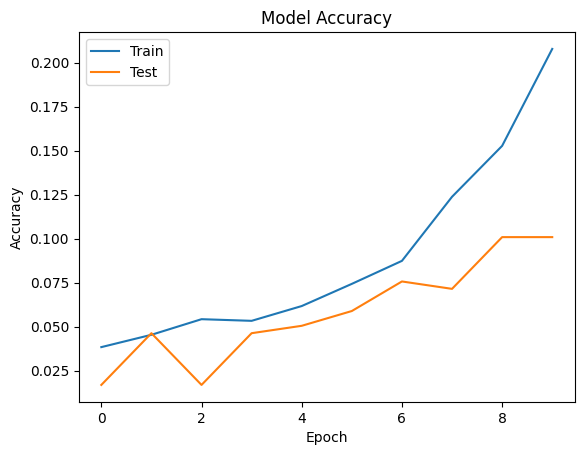

In [143]:
# Visualize training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Download the `history.pkl` file which contains the information of the training history of your model and will be used to compute your grade. You can download this file by running the cell below:

## See our model in action

After all our work it is finally time to see our model generating text.

Run the cell below to generate the next 100 words of a seed text.

In [145]:
seed_text = "please do not"
next_words = 20

for _ in range(next_words):
	# Convert the text into sequences
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	# Pad the sequences
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	# Get the probabilities of predicting a word
	predicted = model.predict(token_list, verbose=0)
	# Choose the next word based on the maximum probability
	predicted = np.argmax(predicted, axis=-1).item()
	# Get the actual word from the word index
	output_word = tokenizer.index_word[predicted]
	# Append to the current text
	seed_text += " " + output_word

print(seed_text)

please do not the weighted companion cube cube the enrichment center the enrichment center reminds you the enrichment center reminds you the enrichment
